In [1]:
import numpy as np
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
from scipy import misc
from scipy.spatial import distance

%matplotlib inline

# facenetのダウンロード
- https://github.com/davidsandberg/facenet
- クローンしたパスをfacenet_pathに
- tensorflowのversionは1.2が必要

# 訓練済みのモデルのダウンロード
- [MS-Celeb-1Mで訓練したモデル](https://drive.google.com/file/d/0B5MzpY9kBtDVOTVnU3NIaUdySFE/edit)
- [CASIA-WebFace](https://drive.google.com/file/d/0B5MzpY9kBtDVOTVnU3NIaUdySFE/edit)
- ダウンロードしたパスをmodelに

# ももくろ写真のダウンロード
- [鈴木さんのGoogleDrive](https://drive.google.com/drive/u/1/folders/1wb1H0Rwk9CJnobxcsmxddClrjZLb43M9)
- ダウンロードしたパスをimage_dir_basepathに

In [2]:
facenet_path = '../code/facenet/'
model = facenet_path + 'model/20170512-110547'
image_dir_basepath = facenet_path + 'data/images/momo_img/'

In [3]:
import sys
sys.path.append(facenet_path + 'src/')
import facenet
import align.detect_face

In [4]:
image_size = 160
margin = 44
batch_size = 1000

# 顔抽出のテスト

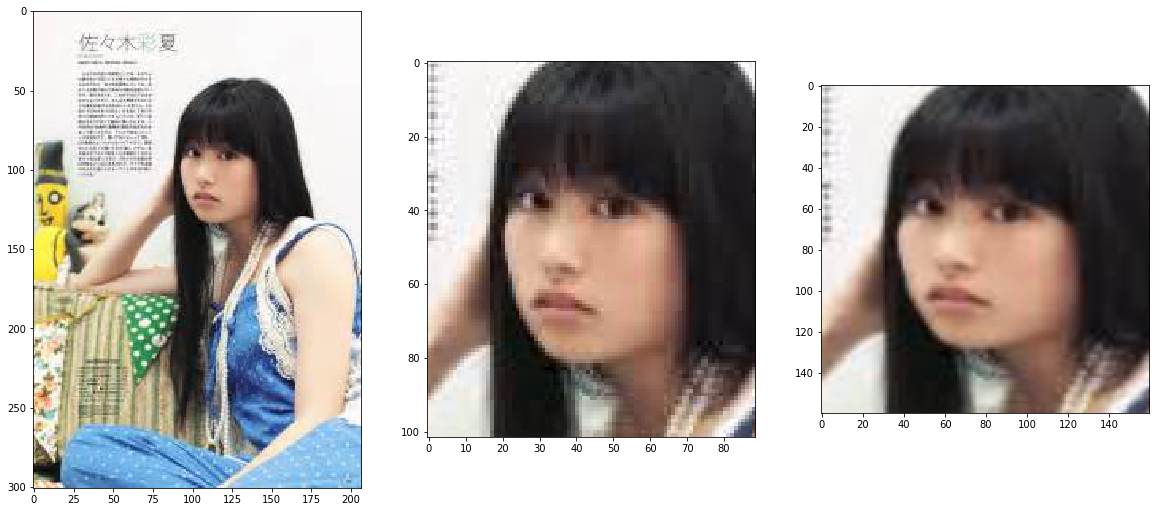

In [5]:
image_dirpath = os.path.abspath(image_dir_basepath + 'ayaka_image/')
image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]

img_num = 4

extracted_filepaths = []
minsize = 20
threshold = [0.6, 0.7, 0.7]
factor = 0.709

with tf.Graph().as_default():
    with tf.Session() as sess:
        pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
        img = misc.imread(image_filepaths[img_num])
        img_size = np.array(img.shape)[0:2]
        bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet,
                                                          threshold, factor)
        det = bounding_boxes[0, :4]
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img_size[1])
        bb[3] = np.minimum(det[3]+margin/2, img_size[0])
        cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
        aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
        prewhitened = facenet.prewhiten(aligned)

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(cropped)
plt.subplot(1,3,3)
plt.imshow(aligned)

# 関数定義

In [6]:
# 顔の切り取りを行う
# 失敗することがあるので、成功した写真のパスも返す
def load_and_align_data(image_paths, image_size, margin):
    minsize = 20
    threshold = [0.6, 0.7, 0.7]
    factor = 0.709

    extracted_filepaths = []
    img_list = []
    with tf.Graph().as_default():
        with tf.Session() as sess:
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
            nrof_samples = len(image_paths)
            for i in range(nrof_samples):
                # print('%1d: %s' % (i, os.path.basename(image_paths[i])))
                img = misc.imread(image_paths[i])
                img_size = np.array(img.shape)[0:2]
                try:
                    bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet,
                                                                      threshold, factor)
                    det = bounding_boxes[0, :4]
                    bb = np.zeros(4, dtype=np.int32)
                    bb[0] = np.maximum(det[0]-margin/2, 0)
                    bb[1] = np.maximum(det[1]-margin/2, 0)
                    bb[2] = np.minimum(det[2]+margin/2, img_size[1])
                    bb[3] = np.minimum(det[3]+margin/2, img_size[0])
                    # 顔の位置を切り取り
                    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
                    # 160*160にリサイズ
                    aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
                    # データを標準化
                    prewhitened = facenet.prewhiten(aligned)
                    extracted_filepaths.append(image_paths[i])
                    img_list.append(prewhitened)
                except:
                    print("{} cannot extract_image_align".format(os.path.basename(image_paths[i])))
    
    return img_list, extracted_filepaths

In [7]:
# 訓練済みのモデルを使って顔写真の特徴量を計算
# 特徴量は128次元のベクトル
def calc_emb(images):
    embs = []
    
    with tf.Graph().as_default():
        with tf.Session() as sess:
            facenet.load_model(model)
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

            for i in range(0, len(images), batch_size):
                feed_dict = {images_placeholder: images[i:i+batch_size],
                             phase_train_placeholder: False}
                emb = sess.run(embeddings, feed_dict=feed_dict)
                embs.append(emb)
    
    embs = np.concatenate(embs, axis=0)
    return embs

In [8]:
# データ生成
# 入力はメンバーの名前
# 返り値は写真の名前をkey、写真への絶対パスと特徴量がvalueの辞書
def gen_data(name):
    if name not in ('ayaka', 'kanako', 'momoka', 'reni', 'shiori'):
        print('そんなメンバーはいない')
        return 0
    image_dirpath = os.path.abspath(image_dir_basepath +'{}_image/'.format(name))
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    images, target_filepaths = load_and_align_data(image_filepaths, image_size, margin)
    embs = calc_emb(images)
    data = {}
    for i in range(len(images)):
        data[os.path.basename(target_filepaths[i])[:-4]] = [target_filepaths[i], embs[i]]
    return data

In [9]:
# 距離計算の関数
def calc_dist(data, img_name0, img_name1):
    return distance.euclidean(data[img_name0][1], data[img_name1][1])

def calc_dist_plot(data, img_name0, img_name1):
    print(distance.euclidean(data[img_name0][1], data[img_name1][1]))
    plt.subplot(1, 2, 1)
    plt.imshow(misc.imread(data[img_name0][0]))
    plt.subplot(1, 2, 2)
    plt.imshow(misc.imread(data[img_name1][0]))

In [10]:
# pickleで保存してある
# 新しく作る場合はフラグをTrueに
gen_flag = False

if gen_flag:
    ayaka_data = gen_data('ayaka')
    kanako_data = gen_data('kanako')
    momoka_data = gen_data('momoka')
    reni_data = gen_data('reni')
    shiori_data = gen_data('shiori')

    all_data = ayaka_data.copy()
    all_data.update(kanako_data)
    all_data.update(momoka_data)
    all_data.update(reni_data)
    all_data.update(shiori_data)

    with open('all_data.pkl', 'wb') as f:
        pickle.dump(all_data, f)
else:
    with open('all_data.pkl', 'rb') as f:
        all_data = pickle.load(f)
    ayaka_data = {}
    kanako_data = {}
    momoka_data = {}
    reni_data = {}
    shiori_data = {}
    for k, v in all_data.items():
        if k[:5] == 'ayaka':
            ayaka_data[k] = v
        elif k[:6] == 'kanako':
            kanako_data[k] = v
        elif k[:6] == 'momoka':
            momoka_data[k] = v
        elif k[:4] == 'reni':
            reni_data[k] = v
        elif k[:6] == 'shiori':
            shiori_data[k] = v

ayaka260.jpg cannot extract_image_align
ayaka318.jpg cannot extract_image_align
ayaka427.jpg cannot extract_image_align
ayaka369.jpg cannot extract_image_align
ayaka413.jpg cannot extract_image_align
ayaka431.jpg cannot extract_image_align
ayaka400.jpg cannot extract_image_align
ayaka320.jpg cannot extract_image_align
ayaka376.jpg cannot extract_image_align
ayaka363.jpg cannot extract_image_align
Model directory: ../code/facenet/model/20170512-110547
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
INFO:tensorflow:Restoring parameters from ../code/facenet/model/20170512-110547/model-20170512-110547.ckpt-250000
kanako255.jpg cannot extract_image_align
kanako348.jpg cannot extract_image_align
kanako414.jpg cannot extract_image_align
Model directory: ../code/facenet/model/20170512-110547
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
INFO:tensorflow:Restoring parameters from ../code/facenet/model/2

0.8330099582672119


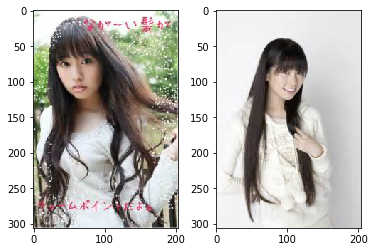

In [11]:
calc_dist_plot(all_data, 'ayaka0', 'ayaka3')

# 同一人物とそうでない場合に、距離にどのくらい差があるか

In [12]:
def extract_emb(data):
    emb = []
    for v in data.values():
        emb.append(v[1])
    emb = np.array(emb)
    return emb

def calc_person_dist(emb0, emb1):
    dist = []
    if np.array_equal(emb0, emb1):
        for i in range(emb0.shape[0]):
            for j in range(i+1, emb1.shape[0]):
                dist.append(distance.euclidean(emb0[i], emb1[j]))
    else:       
        for i in range(emb0.shape[0]):
            for j in range(i, emb1.shape[0]):
                dist.append(distance.euclidean(emb0[i], emb1[j]))
    dist = np.array(dist)
    return dist

In [13]:
[ayaka, kanako, momoka, reni, shiori] = range(5)
data = [ayaka_data, kanako_data, momoka_data, reni_data, shiori_data]
embs = [extract_emb(dt) for dt in data]

dists = [[calc_person_dist(embs[i], embs[j]) if i >= j else 0 for i in range(5)] for j in range(5)]
dists = [[dists[i][j] if i < j else dists[j][i] for i in range(5)] for j in range(5)]
dists_mean = np.array([[np.mean(dists[i][j]) for i in range(5)] for j in range(5)])
dists_std = np.array([[np.std(dists[i][j]) for i in range(5)] for j in range(5)])

あまり差がない！！

In [14]:
dists_mean

array([[ 0.88590221,  1.02582068,  1.00533316,  1.01680176,  0.99632671],
       [ 1.02582068,  0.99986459,  1.05302084,  1.09543924,  1.05590935],
       [ 1.00533316,  1.05302084,  0.91340803,  1.06619779,  1.02237046],
       [ 1.01680176,  1.09543924,  1.06619779,  1.03130384,  1.0854417 ],
       [ 0.99632671,  1.05590935,  1.02237046,  1.0854417 ,  0.97580471]])

In [15]:
dists_std

array([[ 0.20227213,  0.16537318,  0.16099592,  0.17493934,  0.18230504],
       [ 0.16537318,  0.20278261,  0.16110233,  0.16190945,  0.16832334],
       [ 0.16099592,  0.16110233,  0.19590911,  0.15664861,  0.16342225],
       [ 0.17493934,  0.16190945,  0.15664861,  0.19771432,  0.16843741],
       [ 0.18230504,  0.16832334,  0.16342225,  0.16843741,  0.21551482]])